In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import os
from natsort import natsorted

In [2]:
def plot_image(img, figsize_in_inches=(5,5)):
    fig, ax = plt.subplots(figsize=figsize_in_inches)
    ax.imshow(img)
    plt.show()
    
def plot_images(imgs, figsize_in_inches=(5,5)):
    fig, axs = plt.subplots(1, len(imgs), figsize=figsize_in_inches)
    for col, img in enumerate(imgs):
        axs[col].imshow(img)
    plt.show()

In [3]:
# Define the folder containing your images
folder_path = "D:/Panorama_normalized"

# Define the image sizes you want
original_size = (4056, 3040)
medium_size = (895, 671)
low_size = (274, 365)

# Initialize empty lists for each size
original_images_8bit = []
medium_images_8bit = []
low_images_8bit = []

original_images_16bit = []
medium_images_16bit = []
low_images_16bit = []

# Read in the images from the folder and sort them using natsort
files = natsorted(os.listdir(folder_path))

# Loop through each image in the folder 
for file_name in files:
    # Read the image using cv2
    img_16bit = cv2.imread(os.path.join(folder_path, file_name), cv2.IMREAD_UNCHANGED)
    # Convert to 8-bit
    img_8bit = np.uint8(img_16bit / 256)
    # Resize the image to each size and add to the appropriate list
    original_images_8bit.append(cv2.resize(img_8bit, original_size))
    medium_images_8bit.append(cv2.resize(img_8bit, medium_size))
    low_images_8bit.append(cv2.resize(img_8bit, low_size))

    
    original_images_16bit.append(cv2.resize(img_16bit, original_size))
    medium_images_16bit.append(cv2.resize(img_16bit, medium_size))
    low_images_16bit.append(cv2.resize(img_16bit, low_size))


In [4]:
print(np.shape(medium_images_16bit[0]))
print(medium_images_16bit[0].dtype)

print(np.shape(medium_images_8bit[0]))
print(medium_images_8bit[0].dtype)

(671, 895)
uint16
(671, 895)
uint8


In [9]:
# Initialize ORB detector
sift = cv2.SIFT_create()

keypoints = []
descriptors = []

# Loop through the medium size images and detect ORB features
for i, img in enumerate(medium_images_8bit):
    
    # Detect keypoints and compute descriptors
    kp, des = sift.detectAndCompute(img, None)

    keypoints.append(kp)
    descriptors.append(des)

    # Print number of keypoints detected
    print("Image {} - Keypoints: {}, Descriptors: {}".format(i+1, len(kp), des.shape))

Image 1 - Keypoints: 60, Descriptors: (60, 128)
Image 2 - Keypoints: 37, Descriptors: (37, 128)
Image 3 - Keypoints: 35, Descriptors: (35, 128)
Image 4 - Keypoints: 30, Descriptors: (30, 128)
Image 5 - Keypoints: 78, Descriptors: (78, 128)
Image 6 - Keypoints: 90, Descriptors: (90, 128)
Image 7 - Keypoints: 102, Descriptors: (102, 128)
Image 8 - Keypoints: 164, Descriptors: (164, 128)
Image 9 - Keypoints: 227, Descriptors: (227, 128)
Image 10 - Keypoints: 169, Descriptors: (169, 128)


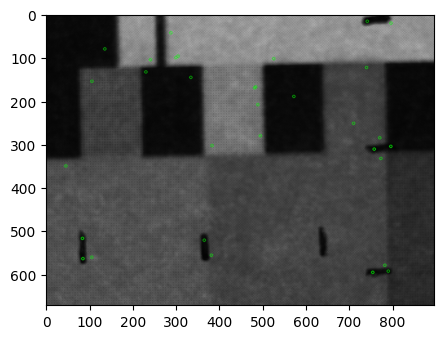

In [10]:
# Draw keypoints on image
img_with_keypoints = cv2.drawKeypoints(medium_images_8bit[1], keypoints[1], None, color=(0, 255, 0))

plot_image(img_with_keypoints, (5,5))

In [56]:
# Initialize FLANN-based matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Set the threshold for a good match
threshold = 0.5

# Loop through all possible image pairs
for i in range(len(medium_images_8bit)):
    for j in range(i+1, len(medium_images_8bit)):
        
        # Match the feature descriptors of image i and j
        matches = flann.knnMatch(descriptors[i], descriptors[j], k=4)

        # Filter the matches using Lowe's ratio test
        good_matches = []
        for m,n,o,p in matches:
            if m.distance < 0.75*n.distance:
                good_matches.append(m)

        # Use RANSAC to find the inliers
        if len(good_matches) > 4:
            src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
            dst_pts = np.float32([keypoints[j][m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Calculate the number of inliers and matches
            num_matches = len(good_matches)
            num_inliers = np.sum(mask)

        # Verify the image pair using the ratio of inliers to (8+0.3*matches)
            ratio = num_inliers / (8+0.3*num_matches)
            if ratio > threshold:
                print("Image pair ({}, {}) - GOOD match with ratio {}".format(i+1, j+1, ratio))
            else:
                print("Image pair ({}, {}) - BAD match with ratio {}".format(i+1, j+1, ratio))


Image pair (1, 2) - GOOD match with ratio 0.5309734513274336
Image pair (1, 5) - GOOD match with ratio 0.6896551724137931
Image pair (1, 6) - BAD match with ratio 0.45454545454545453
Image pair (1, 7) - BAD match with ratio 0.0
Image pair (1, 10) - GOOD match with ratio 1.25
Image pair (2, 3) - GOOD match with ratio 0.7534246575342466
Image pair (2, 6) - BAD match with ratio 0.0
Image pair (2, 8) - BAD match with ratio 0.49504950495049505
Image pair (2, 9) - GOOD match with ratio 0.7758620689655172
Image pair (2, 10) - BAD match with ratio 0.0
Image pair (3, 4) - BAD match with ratio 0.0
Image pair (3, 6) - GOOD match with ratio 0.5882352941176471
Image pair (3, 7) - BAD match with ratio 0.44247787610619466
Image pair (3, 8) - GOOD match with ratio 0.6542056074766356
Image pair (3, 9) - BAD match with ratio 0.42105263157894735
Image pair (3, 10) - BAD match with ratio 0.0
Image pair (4, 5) - GOOD match with ratio 0.9016393442622951
Image pair (4, 6) - BAD match with ratio 0.0
Image pai